## **Analisis y clasificación de las reviews y comentarios en el sector de los videojuegos**
## **ANÁLISIS REVIEWS**

In [13]:
import requests
import nltk
import pandas as pd
import time
import random
from random import randint
import shutil
import pickle
import os
import nltk
import nltk.text
import nltk.corpus
from wordcloud import WordCloud, STOPWORDS
from time import sleep, strftime
import numpy as np
import re
import matplotlib.pyplot as plt

In [14]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [15]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Cargar nuestros datos

In [19]:
df_review=pd.read_pickle('/Users/Eugenio/Documents/proyecto_reviews1.pkl')
df_sumario=pd.read_pickle('/Users/Eugenio/Documents/proyecto_sumario.pkl')
df_review_switch=pd.read_pickle('/Users/Eugenio/Documents/proyecto_reviews4.pkl')
df_sumario_switch=pd.read_pickle('/Users/Eugenio/Documents/proyecto_sumario4.pkl')
df_review.drop_duplicates(subset=['Titulo', 'Plataforma', 'Metascore', 'Numero_criticas_positivas'], inplace=True)
df_play= pd.merge(left=df_sumario[df_sumario['Plataforma']=='PlayStation 4'], right=df_review[df_review['Plataforma']=='PlayStation 4'], on = "Titulo")
df_xbox= pd.merge(left=df_sumario[df_sumario['Plataforma']=='Xbox One'], right=df_review[df_review['Plataforma']=='Xbox One'], on = "Titulo")
df_switch= pd.merge(left=df_sumario_switch, right=df_review_switch, on = "Titulo")
df=pd.concat([df_play,df_xbox,df_switch], axis=0, ignore_index=True)

In [20]:
df.isnull().sum()/len(df)*100

Titulo                       0.000000
Plataforma_x                 0.000000
Fecha_salida_x               0.000000
Resumen                      1.889913
Desarrolladora               0.047248
Genero                       0.000000
Rating                       7.252540
Metascore_x                  0.000000
Puntuacion_usuarios          7.063548
Plataforma_y                 0.000000
Fecha_salida_y               0.000000
Metascore_y                  0.000000
Numero_criticas_positivas    0.000000
Numero_criticas_mixtas       0.000000
Numero_criticas_negativas    0.000000
Puntuaciones_criticos        0.000000
Medios                       0.000000
Fecha_review                 0.000000
Reviews                      0.000000
dtype: float64

In [21]:
print('Valores perdidos Resumen:', sum(df.Resumen.isnull().values.ravel()))
print('Valores perdidos Puntuacion_usuarios:', sum(df.Puntuacion_usuarios.isnull().values.ravel()))
print('Valores perdidos Rating:', sum(df.Rating.isnull().values.ravel()))
print('Valores perdidos Desarrolladora:', sum(df.Desarrolladora.isnull().values.ravel()))

Valores perdidos Resumen: 80
Valores perdidos Puntuacion_usuarios: 299
Valores perdidos Rating: 307
Valores perdidos Desarrolladora: 2


In [22]:
df.dropna(axis=0, inplace = True)
df=df.rename(columns={'Plataforma_x':'Plataforma', 'Fecha_salida_x':'Fecha_salida', 'Metascore_x':'Metascore'})
df.drop(['Plataforma_y', 'Fecha_salida_y', 'Metascore_y'], axis=1, inplace=True)
df1=df.copy()
df1.reset_index(inplace=True)

In [23]:
df.Plataforma.value_counts()

PlayStation 4    1762
Xbox One          969
Switch            905
Name: Plataforma, dtype: int64

In [24]:
for x,i in enumerate(df1["Genero"]):
    for Genero in i:
        df1.at[x, Genero] = 1
df1 = df1.fillna(0)

In [25]:
valores_suma = df1.iloc[:,18:].sum()

In [26]:
print(valores_suma.index[22], valores_suma[22])
print(valores_suma.index[23], valores_suma[23])

Puzzle 106.0
Stacking 10.0


In [27]:
df1=df1.iloc[:,:42]
df1.drop(['index'], axis=1, inplace=True)
df1=df1.reset_index()
df2 = df1.set_index('index')[['Puntuaciones_criticos', 'Medios', 'Fecha_review', 'Reviews']].apply(pd.Series.explode)
df3=df1[['index','Titulo', 'Plataforma', 'Fecha_salida', 'Resumen',
       'Desarrolladora', 'Genero', 'Rating', 'Metascore',
       'Puntuacion_usuarios', 'Numero_criticas_positivas',
       'Numero_criticas_mixtas', 'Numero_criticas_negativas','Action Adventure', 'Open-World', 'Modern', 'Role-Playing',
       'Japanese-Style', 'General', 'Linear', 'Survival', 'Action',
       'Platformer', '3D', 'Fantasy', 'Action RPG', 'Western-Style',
       'Massively Multiplayer', '2D', 'Miscellaneous', 'Shooter',
       'First-Person', 'Tactical', 'Adventure', 'Rail', 'Arcade', 'Puzzle']]
df4=pd.merge(left=df3, right=df2, on = "index")

In [28]:
def etiquetar(Puntuaciones_criticos):
    if Puntuaciones_criticos>74:
        return 'positiva'
    elif Puntuaciones_criticos<49:
        return 'negativa'
    else:
        return 'mixta'

In [29]:
df4['Puntuaciones_criticos']=df4['Puntuaciones_criticos'].apply(lambda x: float(x))
df4['etiqueta']=df4['Puntuaciones_criticos'].apply(etiquetar)
df4['Metascore']=df4['Metascore'].apply(lambda x: float(x))
df4['Puntuacion_usuarios']=df4['Puntuacion_usuarios'].apply(lambda x: float(x))
df4['Numero_criticas_positivas']=df4['Numero_criticas_positivas'].apply(lambda x: float(x))
df4['Numero_criticas_mixtas']=df4['Numero_criticas_mixtas'].apply(lambda x: float(x))
df4['Numero_criticas_negativas']=df4['Numero_criticas_negativas'].apply(lambda x: float(x))

In [30]:
def preprocessor(text):
    text=str(text)
    text = re.sub(r'<[^>]*>', '', text) #Para eliminar las etiquetas HTML
    text = re.sub(r'[\W]+', ' ', text.lower()) #Eliminamos todos los caracteres que no sean palabras
    
    return text

In [31]:
df4['reviews_clean']=df4['Reviews'].apply(preprocessor)

In [32]:
stop = nltk.corpus.stopwords.words("english")

In [33]:
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return nltk.word_tokenize(text,"english")


def tokenizer_lemma(text):
    return [lemmatizer.lemmatize(word) for word in tokenizer(text)]

In [34]:
stop.append('ha')

In [35]:
df4['reviews_clean']=df4['reviews_clean'].apply(lambda x:[w for w in tokenizer_lemma(x) if w not in stop])

In [36]:
df4['reviews_clean']

0        [amazing, western, lover, game, probably, offe...
1        [simply, incredible, much, rockstar, accounted...
2        [open, world, game, make, feel, physically, pr...
3        [game, restraint, brutal, sucker, punch, tale,...
4        [unprecedented, big, flawless, game, great, st...
                               ...                        
83416    [dialogue, might, atrocious, seen, date, game,...
83417    [nothing, positive, highlight, vroom, night, s...
83418    [lowest, low, potential, skill, depth, talent,...
83419    [vroom, night, sky, probably, worst, priced, g...
83420    [nindie, looking, stay, away, visuals, reminis...
Name: reviews_clean, Length: 83421, dtype: object

In [37]:
dict_categorias_target={
    'positiva':0,
    'mixta'   :1, 
    'negativa':2
}
def categorit(categoria):
    return dict_categorias_target[categoria]
df4['target']=df4['etiqueta'].apply(categorit)

**Nube de palabras**

In [38]:
reviews_wc = WordCloud(background_color='white', max_words=len(df4['reviews_clean']), stopwords=stop)

In [39]:
frases = df4['reviews_clean'].apply(lambda x:' '.join(x))
text = " ".join(review for review in df4['reviews_clean'].apply(lambda x:' '.join(x)))

In [40]:
reviews_wc.generate(text)

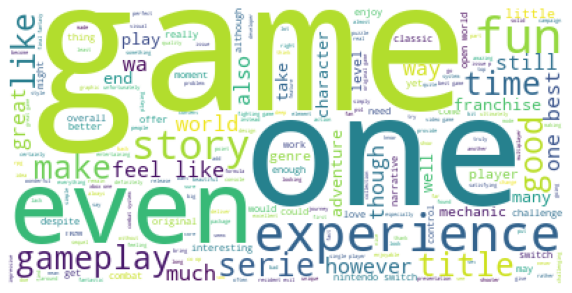

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reviews_wc)
ax.axis('off')
plt.show()

In [42]:
nltk.FreqDist(nltk.Text(nltk.word_tokenize(text,"english"))).most_common(10)

[('game', 64419),
 ('one', 16494),
 ('new', 13570),
 ('experience', 13206),
 ('time', 12827),
 ('like', 12506),
 ('fun', 12481),
 ('great', 12088),
 ('gameplay', 11603),
 ('make', 11236)]

In [43]:
stopwords=STOPWORDS

In [44]:
stopwords.update(["even", "one", "ha", "new", "experience", 'time', 'still', 'fun', 'great', 'gameplay'])

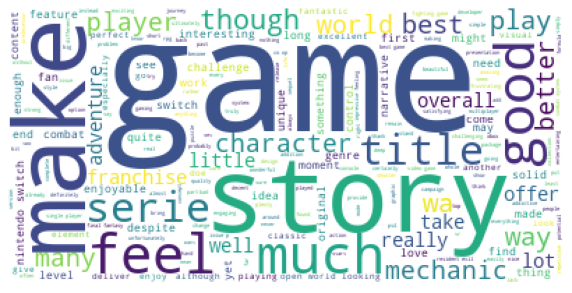

In [45]:
reviews_wc = WordCloud(background_color='white', max_words=len(df4['reviews_clean']), stopwords=stopwords)
reviews_wc.generate(text)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reviews_wc)
ax.axis('off')
plt.show()

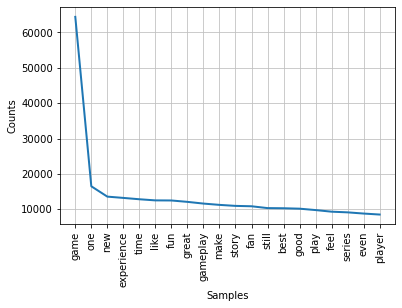

AxesSubplot(0.125,0.125;0.775x0.755)


In [46]:
print(nltk.FreqDist(nltk.Text(nltk.word_tokenize(text,"english"))).plot(20))

In [47]:
nltk.FreqDist(nltk.Text(nltk.word_tokenize(text,"english"))).most_common(10)

[('game', 64419),
 ('one', 16494),
 ('new', 13570),
 ('experience', 13206),
 ('time', 12827),
 ('like', 12506),
 ('fun', 12481),
 ('great', 12088),
 ('gameplay', 11603),
 ('make', 11236)]

**Clasificación - Sentiment analysis**

In [48]:
frases = df4['reviews_clean'].apply(lambda x:' '.join(x))
tfidf = TfidfTransformer()
count = CountVectorizer()
frases = np.array(frases)
bag = count.fit_transform(frases)

In [49]:
df4.etiqueta.value_counts()

positiva    50605
mixta       29166
negativa     3650
Name: etiqueta, dtype: int64

In [50]:
df_under1 = df4[df4['etiqueta']=='positiva'].sample(5000)
df_under2 = df4[df4['etiqueta']=='mixta'].sample(5000)
df5=pd.concat([df_under1,df_under2, df4[df4['etiqueta']=='negativa']], axis=0, ignore_index=True)

In [51]:
frases = df5['reviews_clean'].apply(lambda x:' '.join(x))
count = CountVectorizer()
frases = np.array(frases)
bag = count.fit_transform(frases)

X = tfidf.fit_transform(bag).toarray()
y = np.asarray(df5['target'])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (9555, 17410) (9555,)
Test set: (4095, 17410) (4095,)


0.4358974358974359
[[701 281 469]
 [476 411 644]
 [173 267 673]]
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      1451
           1       0.43      0.27      0.33      1531
           2       0.38      0.60      0.46      1113

    accuracy                           0.44      4095
   macro avg       0.44      0.45      0.43      4095
weighted avg       0.45      0.44      0.43      4095



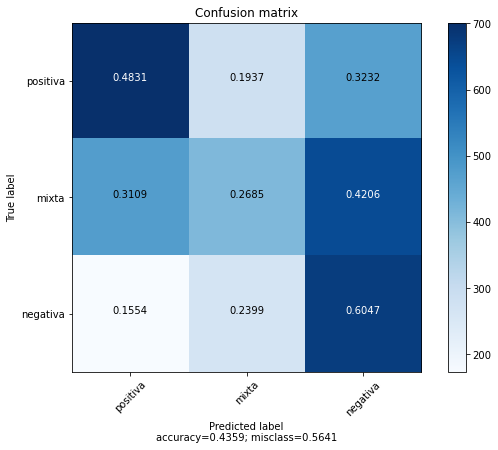

Wall time: 20.7 s


In [52]:
%%time
pipe = Pipeline([('GNB',GaussianNB())])
pipe.fit(X_train,y_train)
print(pipe.score(X_test, y_test))
yhat=pipe.predict(X_test)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm, ['positiva', 'mixta', 'negativa'], title='Confusion matrix', cmap=None, normalize=True)

0.6363858363858363
[[1055  347   49]
 [ 463  847  221]
 [  83  326  704]]
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1451
           1       0.56      0.55      0.56      1531
           2       0.72      0.63      0.67      1113

    accuracy                           0.64      4095
   macro avg       0.65      0.64      0.64      4095
weighted avg       0.64      0.64      0.64      4095



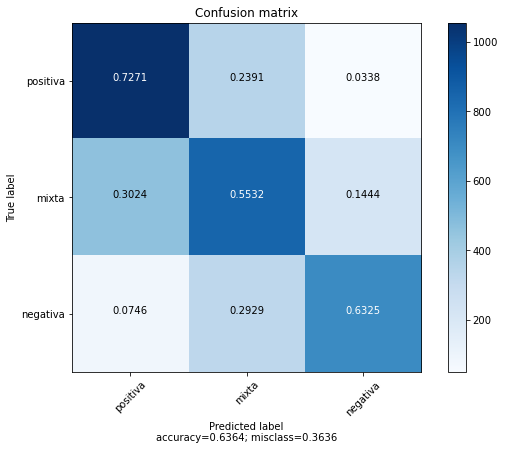

Wall time: 1min 10s


In [53]:
%%time
pipe = Pipeline([('clf', LogisticRegression(max_iter=200))])
pipe.fit(X_train,y_train)
print(pipe.score(X_test, y_test))
yhat=pipe.predict(X_test)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm, ['positiva', 'mixta', 'negativa'], title='Confusion matrix', cmap=None, normalize=True)

0.5914529914529915
[[1076  341   34]
 [ 559  793  179]
 [ 180  380  553]]
              precision    recall  f1-score   support

           0       0.59      0.74      0.66      1451
           1       0.52      0.52      0.52      1531
           2       0.72      0.50      0.59      1113

    accuracy                           0.59      4095
   macro avg       0.61      0.59      0.59      4095
weighted avg       0.60      0.59      0.59      4095



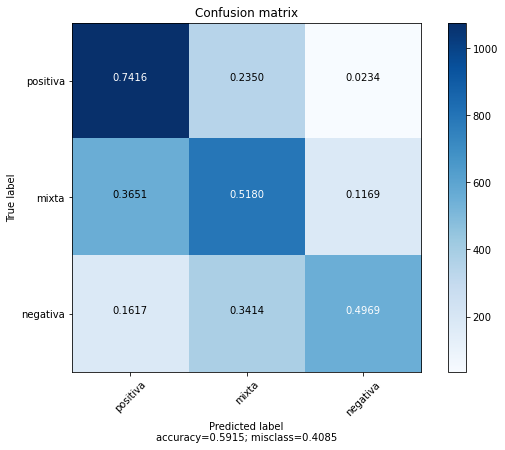

Wall time: 9min 42s


In [54]:
%%time
pipe = Pipeline([('clf', RandomForestClassifier(n_estimators=250))])
pipe.fit(X_train,y_train)
print(pipe.score(X_test, y_test))
yhat=pipe.predict(X_test)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm, ['positiva', 'mixta', 'negativa'], title='Confusion matrix', cmap=None, normalize=True)

Dos etiquetas

In [55]:
df6=pd.concat([df4[df4['etiqueta']=='positiva'].sample(5000), df4[df4['etiqueta']=='negativa']], axis=0, ignore_index=True)

In [56]:
frases = df6['reviews_clean'].apply(lambda x:' '.join(x))

In [57]:
count = CountVectorizer()
frases = np.array(frases)
bag = count.fit_transform(frases)

In [58]:
X = tfidf.fit_transform(bag).toarray()
y = np.asarray(df6['target'])

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (6055, 14662) (6055,)
Test set: (2595, 14662) (2595,)


0.8759152215799615
[[1404   98]
 [ 224  869]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1502
           2       0.90      0.80      0.84      1093

    accuracy                           0.88      2595
   macro avg       0.88      0.86      0.87      2595
weighted avg       0.88      0.88      0.87      2595



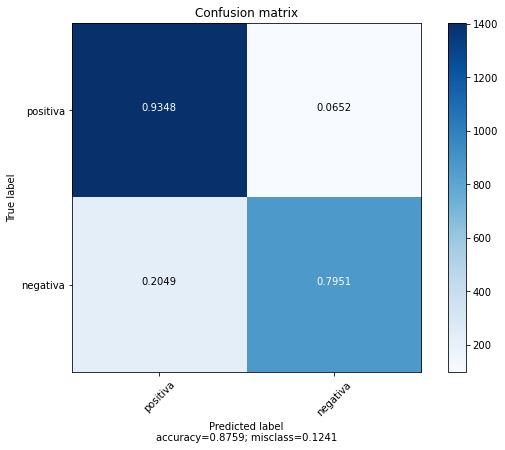

Wall time: 4.49 s


In [59]:
%%time
pipe = Pipeline([('clf', LogisticRegression())])
pipe.fit(X_train,y_train)
print(pipe.score(X_test, y_test))
yhat=pipe.predict(X_test)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm, ['positiva', 'negativa'], title='Confusion matrix', cmap=None, normalize=True)

0.8759152215799615
[[1404   98]
 [ 224  869]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1502
           2       0.90      0.80      0.84      1093

    accuracy                           0.88      2595
   macro avg       0.88      0.86      0.87      2595
weighted avg       0.88      0.88      0.87      2595



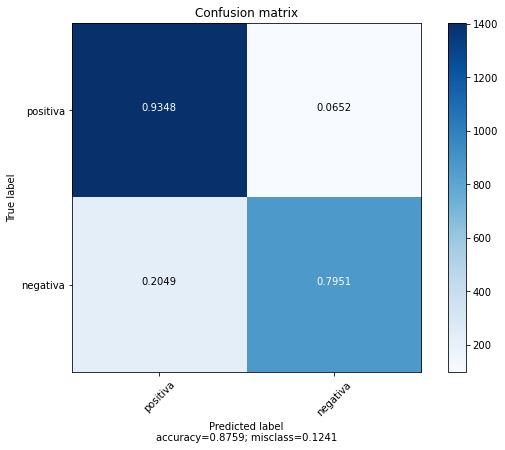

Wall time: 4.66 s


In [60]:
%%time
pipe = Pipeline([('clf', LogisticRegression(max_iter=200))])
pipe.fit(X_train,y_train)
print(pipe.score(X_test, y_test))
yhat=pipe.predict(X_test)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm, ['positiva', 'negativa'], title='Confusion matrix', cmap=None, normalize=True)

0.823121387283237
[[1396  106]
 [ 353  740]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1502
           2       0.87      0.68      0.76      1093

    accuracy                           0.82      2595
   macro avg       0.84      0.80      0.81      2595
weighted avg       0.83      0.82      0.82      2595



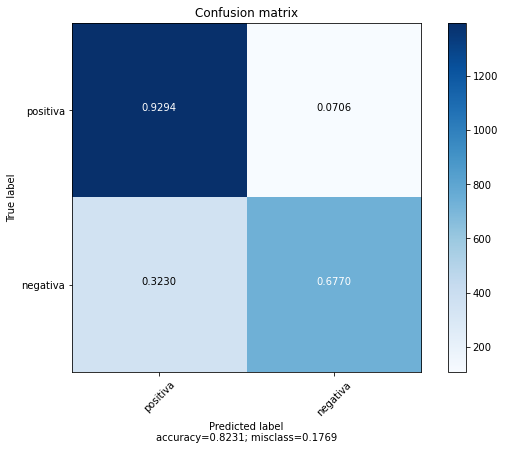

Wall time: 1min 17s


In [61]:
%%time
pipe = Pipeline([('clf', RandomForestClassifier())])
pipe.fit(X_train,y_train)
print(pipe.score(X_test, y_test))
yhat=pipe.predict(X_test)
print(confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
cm = confusion_matrix(y_test, yhat)
plot_confusion_matrix(cm, ['positiva', 'negativa'], title='Confusion matrix', cmap=None, normalize=True)